In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import TQC, RecurrentPPO

In [2]:
env = greenCrabMonthEnvNormalized()

In [34]:
env.step(np.array([0.1, 0.1 , 0]))

(array([-0.99950624,  7.        ]), -0.28807112988386413, False, False, {})

In [35]:
env = greenCrabMonthEnvNormalized()
vec_env = make_vec_env(greenCrabMonthEnvNormalized, n_envs=12)

In [53]:
model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=800_000, 
	progress_bar=True,
)
model.save("ppo_month_observation")

Output()

/opt/conda/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [84]:
ppoAgent = TD3.load("TD3_gcmenorm", device="cpu")

In [85]:
evalEnv = greenCrabMonthEnvNormalized()

In [86]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

import ray
ray.shutdown()

2025-03-19 23:51:09,654	INFO worker.py:1841 -- Started a local Ray instance.


In [87]:
ppo_rew

-1.0836057593700021

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-1.0,-1.000000,-1.0,0.000000,0
1,1,-1.0,3.0,-1.0,-1.000000,-1.0,-0.000061,0
2,2,-1.0,4.0,-1.0,-1.000000,-1.0,-0.000123,0
3,3,-1.0,5.0,-1.0,-1.000000,-1.0,-0.000184,0
4,4,-1.0,6.0,-1.0,-0.998756,-1.0,-0.000245,0


<Axes: xlabel='t'>

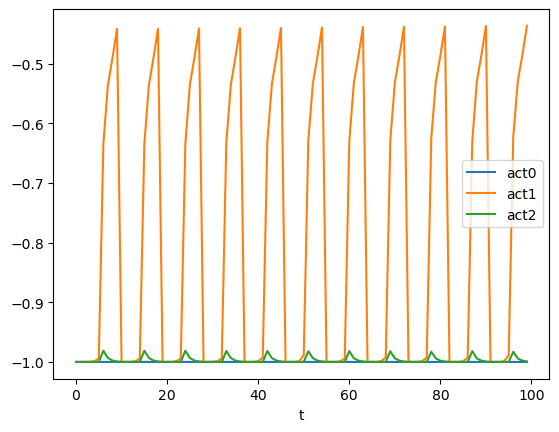

In [88]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
display(ppoDataDF.head())
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

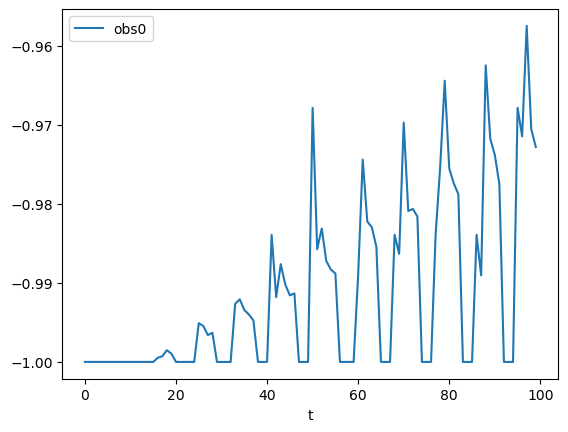

In [89]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])